# GADM process layers
Our clients want to use their country context, so we have to edit our GADM layer and make these new country context fit into GADM layer
Here is the process:
- Locate the polygon we want to substitute in the GADM layer
- Delete it from the layer
- from the new polygon, get coordinate possitions
- select the surrounding countries
- snap the surrounding countries to the polygon

- import layers:
    * GADM layer
    * Client country 

- Main idea: https://gis.stackexchange.com/questions/245064/snapping-multiple-nodes-of-a-polygon-to-the-nodes-of-a-line
- Create a linestring from the polygon: https://gis.stackexchange.com/questions/290756/transforming-a-polygon-to-a-linestring
- Snap Geopandas: https://gis.stackexchange.com/questions/290092/how-to-do-snapping-in-geopandas
- https://gis.stackexchange.com/questions/203058/why-is-shapelys-snapping-geo-snaps-not-working-as-expected

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point
import os
from sys import path
import matplotlib.pyplot as plt


In [2]:
"""Create dataframes of the import data"""
os.chdir(r"C:\Users\ruben.crespo\Documents\03_tests\administrative_units\09_norway_case")

client_country_name = "NOR"

gadm_path = r"C:\Users\ruben.crespo\Documents\03_tests\administrative_units\09_norway_case\administrative_units_un_gadm_level0_can_rus_3.shp"
client_path = r"C:/Users/ruben.crespo/Documents/03_tests/administrative_units/09_norway_case/kommuner_2022_wgs84_navn.shp"
gadm_gdf = gpd.read_file(gadm_path)
client_gdf = gpd.read_file(client_path)

In [3]:
# https://stackoverflow.com/questions/60780959/how-to-filter-a-geodataframe-by-geometry-type
"""Here we check the geometry type and the number of polygons 6f the import file"""
geometry_dic = {}
geometry_type = client_gdf.geom_type.unique().tolist() #we create a list of unique geometries
if len(geometry_type) > 0: #if there are more than one type we list them
    for i in geometry_type:
        geometry_gdf = client_gdf[client_gdf.geom_type == i] #new df with the geometry
        geometry_rows = geometry_gdf.shape[0] #number of elements
        geometry_dic.update({i:geometry_rows}) #add to dic
        
        
print(geometry_dic)

# geometry_str = ''.join(geometry_gdf.geom_type.unique().tolist()) #transform the list to string


{'Polygon': 363}


In [4]:
"""if we have a multipolygon (lots of polygons), we dissolve it"""
client_area_gdf = client_gdf.dissolve()
# check again its geometry
print(str(client_area_gdf.geom_type))

0    Polygon
dtype: object


In [5]:
"""Here we create the GADM boundaries and the client country"""

"""We extract from GADM the client ccountry"""
client_gadm_gdf = gadm_gdf.loc[(gadm_gdf["CID"] == client_country_name)] 

"""Extract from GADM the surrounding countries of the one we want to edit"""
for row_index, row in gadm_gdf.iterrows():
    if row[0] == client_country_name: #the country we are importing
        neightbour_countries_gdf = gadm_gdf[gadm_gdf.geometry.touches(row['geometry'])] #esta bien
    else:
        pass

"""Union the gadm and client layers and dissolve it"""
gadm_countries_gdf = neightbour_countries_gdf.append(client_gadm_gdf)
gadm_boundaries_gdf = gadm_countries_gdf.dissolve() #esta bien

"""Diference of the client and the gadm countries"""
client_country_gs = client_area_gdf.difference(gadm_boundaries_gdf, align= False) #this is the template
client_country_gs = client_area_gdf.difference(client_country_gs, align= False)
client_country_gdf = gpd.GeoDataFrame(geometry=client_country_gs) #esta bien
#time = 1,69

C:\Users\ruben.crespo\AppData\Local\Temp\ipykernel_7136\806335655.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gadm_countries_gdf = neightbour_countries_gdf.append(client_gadm_gdf)


In [6]:
neightbour_countries_gdf.to_file('neightbour_countries_gdf.shp', driver="ESRI Shapefile")

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [24]:
"""We create an empty GeoDataFrame to append inside the country geometries that are finished"""
finished_countries_gs = gpd.GeoSeries()#.reindex_like(new_neightbour_countries_gs)
finished_countries_gs.crs = "EPSG:4326"

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\geoseries.py:207: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)


In [8]:
"""Get the country list, and start doing a difference with both main and surrounding countries""" 
countries = []
for row_index, country in neightbour_countries_gdf.iterrows():
    countries.append(country[0])
countries

['FIN', 'SWE', 'RUS']

In [ ]:
for i in countries:
    """Get the country"""
    country_gdf = neightbour_countries_gdf.loc[(neightbour_countries_gdf["CID"] == i)] 
    
    """Difference of the country and the client"""
    country_gs = country_gdf.difference(client_country_gdf, align= False) #esta bien
    
    """Union of the country and the client"""
    country_union_gs = country_gs.union(client_country_gdf.geometry, align=False)
    
    country_union_gs.to_file('country_union_gs{}.shp'.format(i), driver="ESRI Shapefile")
    
    #el error esta aqui
    # country_union_gs.to_file('country_union_gs{}.shp'.format(i), driver="ESRI Shapefile")
    
    """Union the gadm ones"""
    gadm_country_gdf = neightbour_countries_gdf.loc[(neightbour_countries_gdf["CID"] == i)]
    gadm_union_gs = client_gadm_gdf.geometry.union(gadm_country_gdf.geometry, align=False)
    
    """Get the remaninings of the difference with both gadm union and the other"""
    remainings_gs = gadm_union_gs.difference(country_union_gs, align= False)
    
    gadm_union_gs=None
    
    """Union the remainings with the country"""
    country_gdf = country_gdf.union(remainings_gs, align= False)
    
    """Append new country to the finished gs list"""
    finished_countries_gs = finished_countries_gs.append(country_gdf.geometry)
    #time = 1,20

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

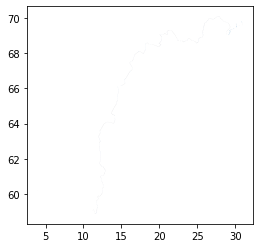

In [34]:
country_gdf = neightbour_countries_gdf.loc[(neightbour_countries_gdf["CID"] == "FIN")] 

"""Difference of the country and the client"""
country_gs = country_gdf.difference(client_country_gdf, align= False) #esta bien

"""Union of the country and the client"""
country_union_gs = country_gs.union(client_country_gdf.geometry, align=False) #vamos a evitar esta union

"""Get the remaninings of the difference with both gadm union and the other"""
remainings_gs = gadm_union_gs.difference(country_union_gs, align= False)
remainings_gs.to_file('remainings_gs.shp', driver="ESRI Shapefile")

"""Split the remainings to the corresponding country"""

remainings_gs.plot()

In [18]:
"""Update the neighbours gdf with the gs"""
neightbour_countries_gdf = neightbour_countries_gdf.set_geometry(finished_countries_gs)
neightbour_countries_gdf

,CID,Shape_Leng,Shape_Area,Country_n,GID,GID_list,GID_n,geometry
61,FIN,231.567531,62.931585,Finland,FIN,FIN,Finland,"MULTIPOLYGON (((22.49806 59.72430, 22.49917 59..."
182,SWE,352.792209,79.228140,Sweden,SWE,SWE,Sweden,"MULTIPOLYGON (((12.94139 55.46292, 12.94195 55..."
377,RUS,70.305320,30.520940,Russia,RUS45,"RUS1,RUS...,RUS84",Murmansk,"MULTIPOLYGON (((40.53750 67.83334, 40.53959 67..."


In [19]:
"""Do the exportation to see wtf is happening"""
neightbour_countries_gdf.to_file('neighbour_new_fixed.shp', driver="ESRI Shapefile")

c:\Users\ruben.crespo\Anaconda3\envs\geoprocessing\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
